<p float="left">
  <img src=attachment:citrine_banner_2.png width="40%" height='10%' align="left" />
  <img src=attachment:nanoHUB_logo.png width="35%" height='10%' align="justify" /> 
</p>
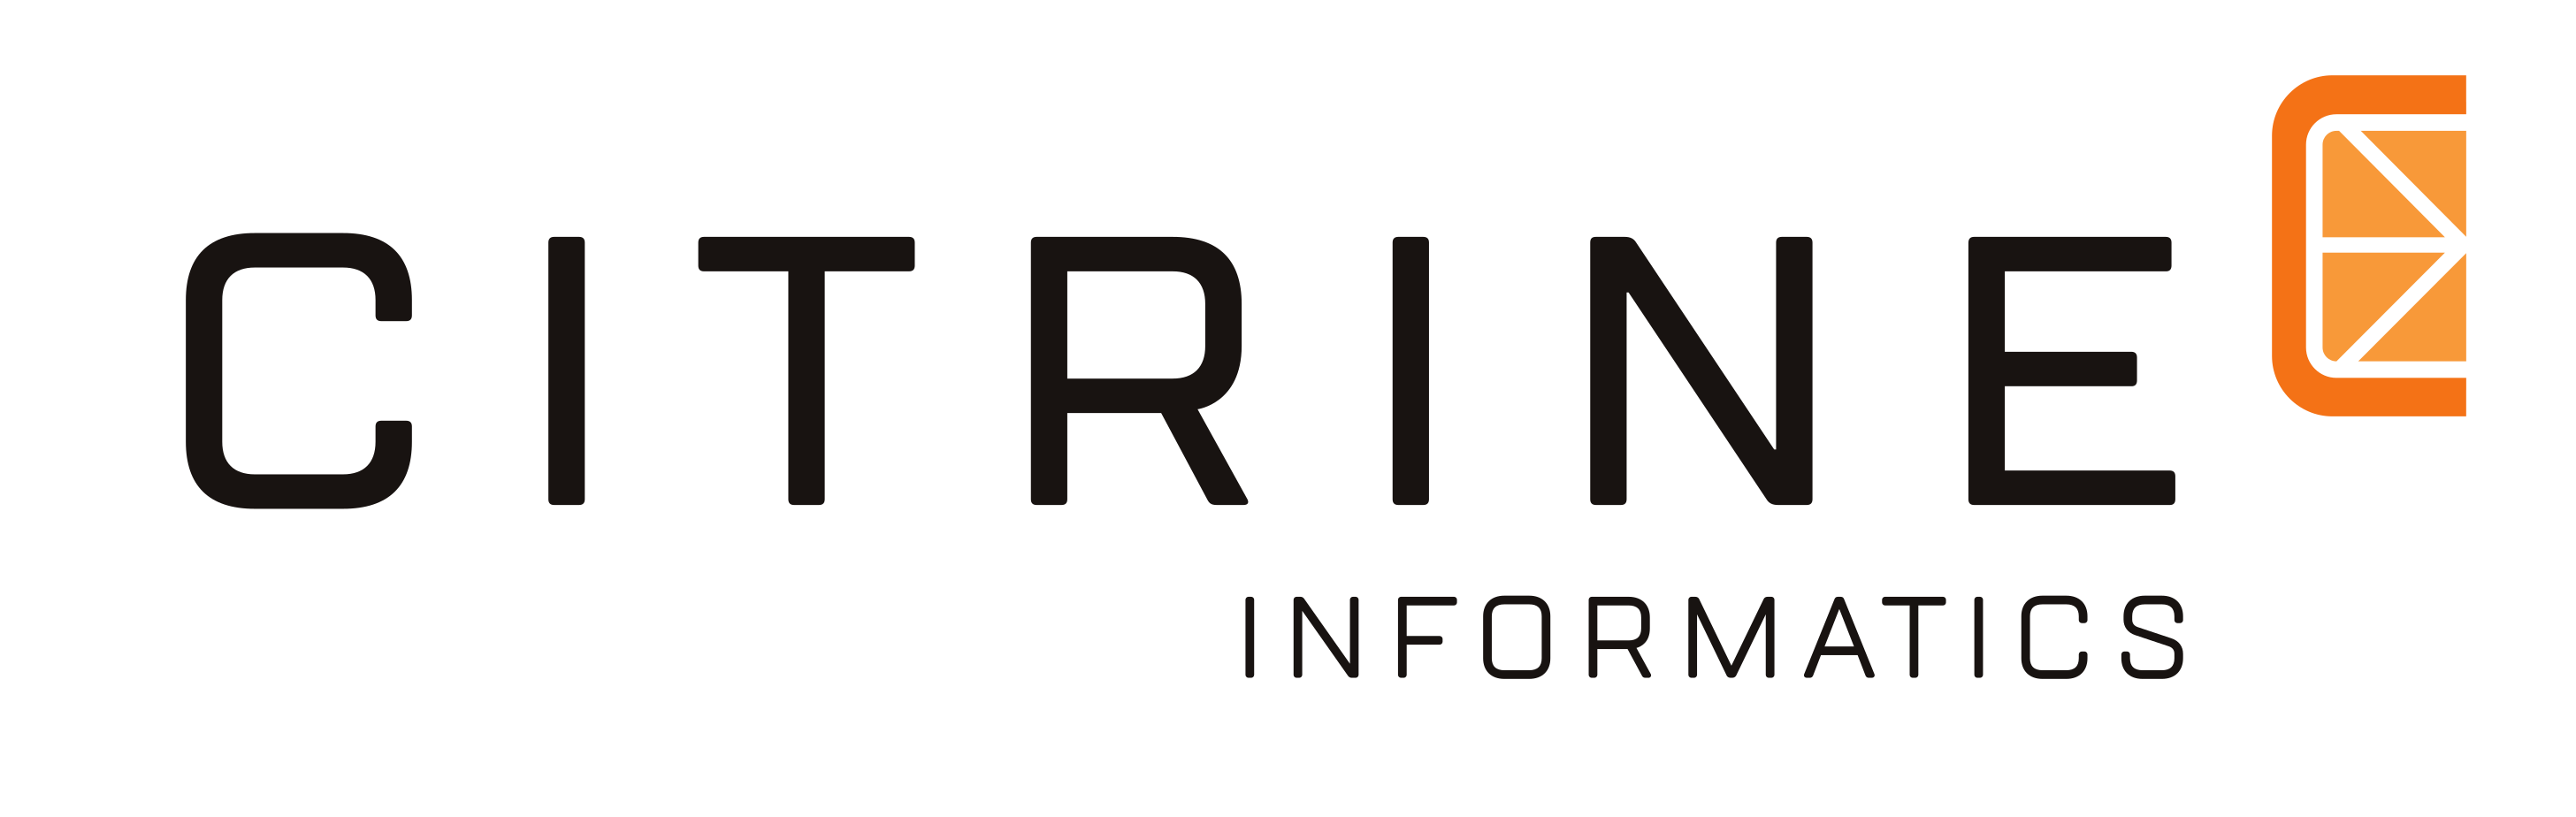
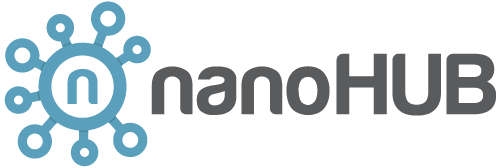

# Machine Learning Algorithms for Ionic Conductivity of LLZO-type Garnets

### Authorship and credits

<b> Based on work published on: </b> [Julia Ling et al.](https://link.springer.com/article/10.1007/s40192-017-0098-z) <br> 
<b> Original notebooks from: </b> <i>Logan Ward</i>, Argonne National Laboratory, and <i>Max Hutchinson</i>, Citrine Informatics. Their Github implementation can be found [here](https://github.com/CitrineInformatics/lolo/blob/develop/python/examples/ling-immi-2017.ipynb).<br>
<b> nanoHUB tools by: </b>  <i>Juan Carlos Verduzco</i> and <i>Alejandro Strachan</i>, Materials Engineering, Purdue University <br>
<b> Database curated by: </b> <i>Juan Carlos Verduzco</i>, Materials Engineering, Purdue University <br>

Figures for our upcoming publication can be found in a separate notebook. [Extra Figures](ActiveLearning_Figures.ipynb). <br>
An analysis of the application of regularization techniques for our ANN model is included in a separate notebook. [Regularization](LLZO_ANN_Regularization.ipynb).


## Overview

In this notebook, I'll introduce different regression machine learning algorithms to predict ionic conductivity of LLZO type garnets using compositional descriptors.

<p float="left">
  <img src=attachment:llzo_cryst.JPG width="30%" align="justify" />
</p>

<center>
Image taken from: Rettenwander, D. A., Geiger, C., Amthauer, G., Blaha, P., <br>
Schwarz, K., Laskowski, R., . . . Wilkening, M. (2014). DFT study of the role of Al 3 in <br>
the fast ion-conductor Li 7-3x Al 3 x La 3 Zr 2 O 12 garnet. Chemistry of Materials, 26(8), 2617-2623.
</center>

<br>

**Outline:**

1. Querying a dataset from Citrination <br>
2. Obtaining features/descriptors from Matminer <br>
3. Processing and Organizing Data <br>
4. Regression Models <br>
    4.1 Neural Network <br>
    4.2 Random Forest (Scikit-learn) <br>
    4.3 Random Forests with Sample Uncertainties (Citrination's Lolopy) <br>
5. Active Learning Approach <br>

Notes: This notebook uses tools from [Citrination](https://citrination.com/) and requires an account with an API key.
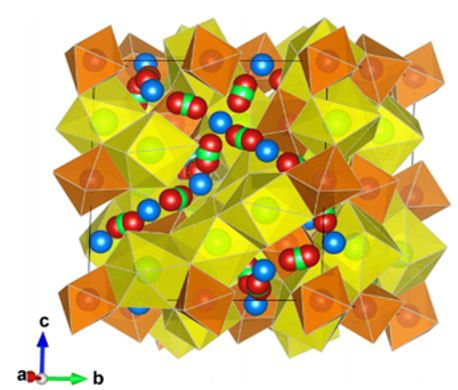

## Libraries

This notebook requires several libraries to be installed. They are separated in blocks depending on their usage.

In [ ]:
import sklearn
import tensorflow as tf

# PLOTTING (MATPLOTLIB)
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# CITRINATION / MATMINER
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

# PYTHON
import pandas as pd
import numpy as np
np.random.seed(44) # Random Seed
import os
import sys
import random
from pymatgen import Composition

# MACHINE LEARNING
import tensorflow as tf
from tensorflow import keras
from keras import initializers, regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# PLOTTING (PLOTLY)
import plotly 
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)


file = open(os.path.expanduser('~/.citrinetools.txt'),"r+")
apikey = file.readline()
file.close()

---
## 1. Querying a Database from Citrination

Matminer offers API tools to facilitate querying of databases like the Materials Project and Citrination. An individual **Citrine Key** is required for the query command <i>CitrineDataRetrieval</i>.

Data is stored in a Pandas Dataframe and the list of possible properties to be queried can be consulted by setting the print_properties_options parameter to **True**.

In [ ]:
cdr = CitrineDataRetrieval(apikey) # Citrine Key

data = cdr.get_dataframe(criteria={'data_set_id': 184812}, print_properties_options=False) # LLZO Database
property_interest = 'Ionic Conductivity' # Property to be queried

display(data.head(n=10))

This is a utility function that will transform the <i>chemicalFormula</i> column into a Matminer composition object, which will be then used to extract features.

In [ ]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

We will use the utility function to transform the <i>chemicalFormula</i> column, and we'll typecast relevant columns into numeric types.
<br>
For this specific application, we'll introduce some filters for the dataframe. We are interested in measurements in structures that are cubic and measured at room temperature (Defined as 18°C < T < 30°C)

In [ ]:
data['composition'] = data['chemicalFormula'].apply(get_compostion) # Transformation of chemicalformula string into Matminer composition
data['Measuring Temperature'] = pd.to_numeric(data['Measuring Temperature'], errors='coerce') # Transformation of Measuring Temp dataframe column from type <str> to a numberic type <int>
data[property_interest] = pd.to_numeric(data[property_interest], errors='coerce') # Transformation of our property of interest dataframe column from type <str> to a numberic type <int>

data = data[data['Crystallographic Structure'] == 'Cubic'] # Filter all non-cubic structures
data = data[data['Measuring Temperature']<30] # Filter all high temperature measurements (over room temperature)
data = data[data['Measuring Temperature']>18] # Filter all low temperature measurements (over room temperature)

data.reset_index(drop=True, inplace=True) # Reindexing of dataframe rows

In order to reduce noise in the neural network and deal with the inconsistencies in the data, we will filter repeated composition values from different measurements and replace the value for ionic conductivity with the median of the values. A similar approach was implemented in this [paper](https://iopscience.iop.org/article/10.1088/1361-651X/aaf8ca).

In [ ]:
dup_indexes = data[data.duplicated(subset = data.columns.tolist()[0], keep=False)].index.tolist()

dup_dataframe =data[data.duplicated(subset = data.columns.tolist()[0], keep=False)]

duplicates = [[dup_dataframe.iloc[x][0], dup_dataframe.iloc[x][4], dup_indexes[x]] for x in range(len(dup_dataframe.index))]
duplicate_compositions = {k: [] for k in set([dup_dataframe.iloc[x][0] for x in range(len(dup_dataframe.index))])}
duplicate_indexes = {k: [] for k in set([dup_dataframe.iloc[x][0] for x in range(len(dup_dataframe.index))])}

for _ in duplicates:
    duplicate_compositions[_[0]].append(_[1])
    duplicate_indexes[_[0]].append(_[2]) 

for k in duplicate_compositions:
    
    duplicate_compositions[k] = np.median(duplicate_compositions[k])
    data.at[duplicate_indexes[k][0], 'Ionic Conductivity'] = duplicate_compositions[k]      
    data = data.drop(duplicate_indexes[k][1:], axis = 0)

data = data.reset_index()
data = data.drop(['index'], axis = 1)

---

## 2. Obtaining features/descriptors from Matminer

Matminer offers a variety of featurizers that can be derived from composition. They can be found [here](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html).  
<br>
In this example, we will query the descriptors listed in the paper by [Ward et al.](https://www.nature.com/articles/npjcompumats201628) plus the ElementFraction() featurizer from Matminer and the experimental measuring temperature. All columns that have a standard deviation of zero are dropped, as they don't contribute new information to the models.

In [ ]:
f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"), cf.ValenceOrbital(props=['avg']), cf.ElementFraction()]) # Featurizers

X = np.array(f.featurize_many(data['composition'], ignore_errors=True)) # Array to store such features

measuring_temp_array = np.array(data['Measuring Temperature']).reshape(-1,1) # Here we are stacking the Measuring temperature numpy array into the features previously calculated to add it as a descriptor. 
X = np.hstack((X,measuring_temp_array))

y = data[property_interest].values # Separate the value we want to predict to use as labels.


# This code is to drop columns with std = 0. 
x_df = pd.DataFrame(X)
x_df = x_df.loc[:, x_df.std() != 0]
print(x_df.shape) # This shape is (#Entries, #Descriptors per entry)

--- 
## 3. Processing and Organizing Data 

For the use in machine learning, we need to split our data into a training set and a testing set. I'm establishing a fixed length of 10% of the entries as testing.
<br>
Normalization is a standard score norm where we subtract the mean and divide by the standard deviation.

In [ ]:
from sklearn.utils import shuffle

all_values = [list(x_df.iloc[x]) for x in range(len(x_df.index))]
all_values = np.array(all_values, dtype = float) 

all_labels = y.copy()

train_percent = 0.90
index_split_at = int (train_percent * len(all_labels))

all_values, all_labels = shuffle(all_values, all_labels, random_state=1)

train_values, test_values = np.split(all_values, [index_split_at])
train_labels, test_labels = np.split(all_labels, [index_split_at])

feature_mean = np.mean(train_values, axis=0)
feature_std = np.std(train_values, axis=0)

train_values = (train_values - feature_mean)/ (feature_std)
test_values = (test_values - feature_mean)/ (feature_std)

print("Shape of Train Values:", train_values.shape)
print("Shape of Train Labels:", train_labels.shape)

print("Shape of Test Values:", test_values.shape)
print("Shape of Test Labels:", test_labels.shape)

--- 

## 4. Regression Models

We will start by creating models for regression with all these entries and descriptors.

### 4.1 Neural Networks


We set the architecture of the sequential feed-forward neural network we'll test. Weights are initialized with a Random Normal distribution and biases are initialized at zero. You can find a summary of the layers, neurons and free parameters to optimize by running the <i>model.summary()</i> command.  

In [ ]:
# DEFINITION OF THE MODEL

kernel_init = initializers.RandomNormal(seed=30)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(90, activation='relu', use_bias = True, input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(60, activation='relu', use_bias = True, kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(30, activation='relu', use_bias = True,  kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, activation='relu', use_bias = True, kernel_initializer=kernel_init, bias_initializer=bias_init))

optimizer = tf.train.AdamOptimizer()

model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

We'll use this training function with a validation mean absolute error (mae) stopping function to train the model. A 10% validation set is set to be taken from the training.
<br>
A figure of training mae vs validation mae is shown. Overfitting occurs when the validation mae starts to increase, so we revert the weights to those of the best epoch.

In [ ]:
# EARLY STOPPING CRITERIAS

#mae_es= keras.callbacks.EarlyStopping(monitor='mean_squared_error', min_delta=1e-8, patience=200, verbose=1, mode='auto', restore_best_weights=True)
valmae_es= keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-10, patience=1000, verbose=1, mode='auto', restore_best_weights=True)


# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') + '                                       \r') # Updates current Epoch Number

EPOCHS = 30000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

history = model.fit(train_values, train_labels, batch_size=90, validation_split=0.1, shuffle=False, epochs=EPOCHS, verbose = False, callbacks=[PrintEpNum(), valmae_es]) #  

# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),label='MAE Training') 
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),label = 'MAE Validation')
print("Loss at best epoch", min(list(np.array(history.history['mean_absolute_error']))))
plt.legend()
plt.show()

[loss, mae] = model.evaluate(train_values, train_labels, verbose=0)
print("Training Set Mean Absolute Error: {:2.4f} units".format(mae))

[loss, mae] = model.evaluate(test_values, test_labels, verbose=0)
print("Testing Set Mean Absolute Error: {:2.4f} units".format(mae))

Our model can now make predictions for our entry values. In this match plot we are analyzing the real value of the label vs the prediction of the trained model. Values that lay on the match line at x=y are accurately predicted.

In [ ]:
test_predictions = model.predict(test_values).flatten() # Prediction of the test set

values = np.concatenate((train_values, test_values), axis=0) # This line joins the values together to evaluate all of them
all_predictions = model.predict(values).flatten()

# MATCH PLOT

layout0= go.Layout(hovermode='closest', xaxis= dict(title=go.layout.xaxis.Title(text='Experimental Conductivity x10<sup>-4</sup> (S/cm)', font=dict(size=18)), zeroline= True, gridwidth= 2),
                   yaxis= dict(title=go.layout.yaxis.Title(text='Predicted Conductivity x10<sup>-4</sup> (S/cm)', font=dict(size=18)), zeroline= True, gridwidth= 2), width = 1000, height=1000)

training = go.Scatter(x = all_labels, y = all_predictions, mode = 'markers', 
                      marker= dict(size= 12, color='green'), name= "All Data") # All values
testing= go.Scatter(x = test_labels, y = test_predictions, mode = 'markers', 
                      marker= dict(size= 9, color= 'red', symbol = 'x'), name= "Testing Data") # Test set

match = go.Scatter(x = [0,20], y = [0,20], mode = 'lines', name = "Match",line= dict( color = 'black')) # Match Line

traces = [match,training,testing]
fig= go.Figure(traces, layout=layout0)
fig.update_yaxes(automargin=True)
iplot(fig)

### 4.2 Random Forest (Scikit-learn)

A random forest from the scikit-learn library is implemented and an equivalent match plot is shown below.

In [ ]:
train_values, test_values = np.split(all_values, [index_split_at])
train_labels, test_labels = np.split(all_labels, [index_split_at])

# We introduce the model here:

from sklearn.ensemble import RandomForestRegressor 

model =  RandomForestRegressor(n_estimators = 500, random_state = 0)
model.fit(train_values, train_labels)

test_pred = model.predict(test_values)
all_pred = model.predict(all_values)

training = go.Scatter(x = all_labels, y = all_pred, mode = 'markers', 
                      marker= dict(size= 12, color='green'), name= "All Data")

testing= go.Scatter(x = test_labels, y = test_pred, mode = 'markers', marker= dict(size= 9, color= 'red', symbol = 'x'), name= "Testing Data")

match = go.Scatter(x = [0,20], y = [0,20], mode = 'lines', name = "Match",line= dict( color = 'black'))

traces = [match,training,testing]
fig= go.Figure(traces, layout=layout0)
fig.update_yaxes(automargin=True)
iplot(fig)

### 4.3 Random Forests with Sample Uncertainties (Citrination's Lolopy)

A random forest from the lolopy library is implemented and an equivalent match plot is shown below. This library can yield the sample-wise uncertainties from a model, following the work from Ling et al, and using a combination of the jackknife-after-bootstrap and infinitesimal-jackknife estimates paired with a montecarlo sampling correction. More details on this uncertainty estimates are discussed in the next section.

$$ \sigma^2_i(x) = Cov_j[n_{i,J}, T_J(x)]^2 + [\overline{T}_{-i}(x) - \overline{T}(x)]^2 - \frac{e\nu}{N_T} $$

In [ ]:
train_values, test_values = np.split(all_values, [index_split_at])
train_labels, test_labels = np.split(all_labels, [index_split_at])

from lolopy.learners import RandomForestRegressor

model =  RandomForestRegressor(num_trees=500)
model.fit(train_values, train_labels)

test_pred, test_std = model.predict(test_values, return_std=True)
all_pred, all_std = model.predict(all_values, return_std=True)

training = go.Scatter(x = all_labels, y = all_pred, mode = 'markers', 
                      marker= dict(size= 12, color='green'), name= "All Data")

testing= go.Scatter(x = test_labels, y = test_pred, mode = 'markers', marker= dict(size= 9, color= 'red', symbol = 'x'), name= "Testing Data", error_y=dict(type='data', array=test_std,visible=True))

match = go.Scatter(x = [0,20], y = [0,20], mode = 'lines', name = "Match",line= dict( color = 'black'))

traces = [match,training,testing]
fig= go.Figure(traces, layout=layout0)
fig.update_yaxes(automargin=True)
iplot(fig)

---
## 5. Active Learning

Active learning is the use of algorithms not for regression, but for the improvement of the input sample space that guides the 'experiments' required to get to such maximum values. Even if it does make predictions for a specific material, its main task is the selection of the most likely candidate to be in a global maxima. Global optimization is based on the assumption that a model can perform better when it can "choose" which point to query next. This is the approach introduced in the paper by Julia Ling et al.


### 5.1 Uncertainty Estimates

The first step on active learning always comes from an approximation of the error in the prediction from the model. Relevant work on how to compute this estimates can be found in publications by [Efron](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/BIO%20262_0.pdf) and [Wager](https://jmlr.org/papers/volume15/wager14a/wager14a.pdf).

To compute an estimate, we need to understand how to compute some important quantities:

<b> Expected Value: </b> The mean of the predictions over all the decision trees represents the expected value for this particular model. The equation to compute this quantity is shown below:
<br>
<br>
$$ E[M(x)] = \frac{1}{N} \sum\limits_{J}^{n_T} T_J(x) $$
<br>

In this equation:

$E[M(x)] \rightarrow $ Expected value of the prediction of the model at point $x$
<br>
$ T_J(x) \rightarrow $ Prediction of tree index $J$ for point $x$
<br>
$n_T $ is the number of trees
<br>
<br>

<b> Variance: </b> For the calculation of the variance, we will compute the value of the <b>"Variance at point x due to training point i "</b>. For this model, we are following on the work from Ling et al, and using a combination of the jackknife-after-bootstrap and infinitesimal-jackknife estimates paired with a montecarlo sampling correction.

$$ \sigma^2_i(x) = Cov_j[n_{i,J}, T_J(x)]^2 + [\overline{T}_{-i}(x) - \overline{T}(x)]^2 - \frac{e\nu}{N_T} $$

In this equation:

$n_{i,J} \rightarrow $ Number of times point $i$ was used to train tree $J$
<br>
$\overline{T}_{-i}(x) \rightarrow $ Average of the prediction over the trees that were fit without using point $i$
<br>
$\overline{T}(x) \rightarrow $ Average of the prediction over all of the trees
<br>
$e$ is Euler's number and $\nu$ is the variance over all trees
<br>
<br>

<b> Uncertainty Estimate: </b> For the calculation of the estimate, we will add the contributions of each of the training points to the variance of our test point, together with an explicit bias model and a noise threshold.

$$ \sigma[M(x)] = \sqrt{ \sum\limits_{i=1}^S max[\sigma^2_i(x), \omega] + \widetilde{\sigma}^{ 2}(x)} $$

In this equation:

$\sigma^2_i(x) \rightarrow $ Variance at point x due to training point i
<br>
$\omega \rightarrow $ Noise threshold 
<br>
$ \widetilde{\sigma}^{ 2}(x) \rightarrow $ Explicit bias model
<br>
$S$ is the number of training points
<br>
<br>

The noise threshold ($\omega$) is defined as:
$$\omega = min_i \sigma^2 [M(x_i)]$$

### 5.2 Information Acquisition Functions

Information Acquisition Functions are based on different criteria on which point is more relevant for the model to query next. In this notebook we discuss MEI (Maximum Expected Improvement), MLI (Maximum Likelihood of Improvement), MU (Maximum Uncertainty) and UCB (Upper Confidence Bound).

<b>MEI.</b> This approach takes the maximum value of the prediction of the model over the possible experiments to run.

<br>
$$ x^* = arg\_max \enspace E[M(x_i)]$$

where $x_i \rightarrow$ Set of possible experiments to run.

<br>

<b>MLI.</b> This approach tells us that we are expecting to query a region for which we see an improvement and sufficient uncertainty to have a high likelihood of getting a larger value.

$$ x^* = arg\_max \enspace \frac{E[M(x_i)] - E[M(x_{best})]}{\sigma[M(x_i)]}$$

where $x_{best} \rightarrow$ Value of our current best case.

<br>

<b>MU.</b> This strategy queries the sample with the highest uncertainty.
<br>
$$ x^* = arg\_max \enspace \sigma[M(x_i)]$$
<br>

<b>UCB.</b> This strategy queries the sample with the maximum value of its mean prediction plus its uncertainty.
<br>
$$ x^* = arg\_max \enspace [E[M(x_i)] + \sigma[M(x_i)]]$$
<br>


---
### 5.3 Approach

We will select an initial set of 10 entries, and we'll make sure the highest value is not in it. If it is, the cell will throw an error, just re-run it so that it can shuffle it again.

In [ ]:
X = all_values.copy()
y = all_labels.copy()

model = RandomForestRegressor()

entry_number_init = 10

in_train = np.zeros(len(data), dtype=np.bool)
in_train[np.random.choice(len(data), entry_number_init, replace=False)] = True
print('Picked {} training entries'.format(in_train.sum()))
assert not np.isclose(max(y), max(y[in_train]))

We will then train the model with this initial set and make predictions:

In [ ]:
model.fit(X[in_train], y[in_train])
y_pred, y_std = model.predict(X[~in_train], return_std=True)

Then, we will query the next material to sample using the four different acquisition functions we described before.

Just as a reminder, the NumPy function <b>argmax</b> returns the index of the maximum value of an array.

In [ ]:
mei_selection = np.argmax(y_pred)
mli_selection = np.argmax(np.divide(y_pred - np.max(y[in_train]), y_std))
mu_selection = np.argmax(y_std)
ucb_selection = np.argmax([sum(x) for x in zip(y_pred, y_std)])

In [ ]:
print('Predicted ' + property_interest + ' of material #{} selected based on MEI: {:.6f} +/- {:.6f}'.format(mei_selection, y_pred[mei_selection], y_std[mei_selection]))
print('Predicted ' + property_interest + ' of material #{} selected based on MLI: {:.6f} +/- {:.6f}'.format(mli_selection, y_pred[mli_selection], y_std[mli_selection]))
print('Predicted ' + property_interest + ' of material #{} selected based on MU: {:.6f} +/- {:.6f}'.format(mu_selection, y_pred[mu_selection], y_std[mu_selection]))
print('Predicted ' + property_interest + ' of material #{} selected based on UCB: {:.6f} +/- {:.6f}'.format(ucb_selection, y_pred[ucb_selection], y_std[ucb_selection]))

This is the algorithm that runs the queries. We start with the initial set and we run 50 experiments to test how long would it take for us to get to the sample with the highest value. Each of the approaches selects a different next point to query and include in the training set.

In [ ]:
n_steps = 50
all_inds = set(range(len(y)))

random_train = [list(set(np.where(in_train)[0].tolist()))]
mei_train = [list(set(np.where(in_train)[0].tolist()))]
mli_train = [list(set(np.where(in_train)[0].tolist()))]
mu_train = [list(set(np.where(in_train)[0].tolist()))]
ucb_train = [list(set(np.where(in_train)[0].tolist()))]
random_train_inds = []
mei_train_inds = []
mli_train_inds = []
ucb_train_inds = []


for i in range(n_steps):
    
    # Maximum Expected Improvement
    
    mei_train_inds = mei_train[-1].copy()    # Initial Set (In the first run) / Current Set (From last iteration, after the first run)
    mei_search_inds = list(all_inds.difference(mei_train_inds)) # All samples not in the current set
    
    
    model.fit(X[mei_train_inds], y[mei_train_inds]) # Training of the random forest model
    mei_y_pred = model.predict(X[mei_search_inds]) # Predictions for the unknown materials

    mei_train_inds.append(mei_search_inds[np.argmax(mei_y_pred)]) # Information Acquisition Function choice and addition to current set
    mei_train.append(mei_train_inds) # Storage of the current set per step    

    # Maximum Likelihood of Improvement
    
    mli_train_inds = mli_train[-1].copy()  
    mli_search_inds = list(all_inds.difference(mli_train_inds))
    
    model.fit(X[mli_train_inds], y[mli_train_inds])
    mli_y_pred, mli_y_std = model.predict(X[mli_search_inds], return_std=True)
    
    mli_train_inds.append(mli_search_inds[np.argmax(np.divide(mli_y_pred - np.max(y[mli_train_inds]), mli_y_std))])
    mli_train.append(mli_train_inds)
    
    # Maximum Uncertainty
    
    mu_train_inds = mu_train[-1].copy()  
    mu_search_inds = list(all_inds.difference(mu_train_inds))
    
    model.fit(X[mu_train_inds], y[mu_train_inds])
    mu_y_pred, mu_y_std = model.predict(X[mu_search_inds], return_std=True)
    
    mu_train_inds.append(mu_search_inds[np.argmax(mu_y_std)])
    mu_train.append(mu_train_inds)
    
    # Upper Conf Bound
    
    ucb_train_inds = ucb_train[-1].copy()  
    ucb_search_inds = list(all_inds.difference(ucb_train_inds))
    
    model.fit(X[ucb_train_inds], y[ucb_train_inds])
    ucb_y_pred, ucb_y_std = model.predict(X[ucb_search_inds], return_std=True)
    
    ucb_train_inds.append(ucb_search_inds[np.argmax([sum(x) for x in zip(ucb_y_pred, ucb_y_std)])])
    ucb_train.append(ucb_train_inds)
    
    # RANDOM
    
    random_train_inds = random_train[-1].copy()    # Initial Set (In the first run) / Current Set (From last iteration, after the first run)
    random_search_inds = list(all_inds.difference(random_train_inds)) # All samples not in the current set

    model.fit(X[random_train_inds], y[random_train_inds]) # Training
    random_y_pred = model.predict(X[random_search_inds]) # Predictions
    
    random_train_inds.append(np.random.choice(random_search_inds)) # Information Acquisition Function choice and addition to current set
    random_train.append(random_train_inds) # Storage of the current set per step 

Finally, we present an interactive plot that shows how the approaches get to the maximum value and how the selection per experiment is distributed across the input space.

In [ ]:
fig, ax = plt.subplots(1,6,figsize=(30,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

# FIRST PLOT, Approach lines

random_line, = ax[0].plot([], [], color='green', label='Random')
mei_line, = ax[0].plot([], [], color='blue', label='MEI')
mli_line, = ax[0].plot([], [], color='red', label='MLI')
mu_line, = ax[0].plot([], [], color='purple', label='MU')
ucb_line, = ax[0].plot([], [], color='orange', label='UCB')
max_line, = ax[0].plot(range(n_steps), [max(y) for m in range(n_steps)], '--', color='black', label='Max Value')

random_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='green')
mei_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='blue')
mli_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='red')
mu_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='purple')
ucb_chk, = ax[0].plot([], [], markersize=10, marker='*', linestyle='None', color='orange')

ax[0].legend(loc=4, prop={'size': 12})
ax[0].grid()
ax[0].set_title("Number of Experiments", fontsize=24)
ax[0].set_xlabel("Number of Experiments", fontsize=16)
ax[0].set_ylabel("Max"+ property_interest, fontsize=16)
mli_line.axes.axis([0, n_steps-1, 0, 1.1*max(y)])
mli_line.axes.get_yaxis().set_tick_params(labelsize=14)


# SECOND PLOT, Random Prediction

all_values_samples = ax[1].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

random_reallabel = [y[index] for index in random_train_inds]

random_initial_set = ax[1].plot(random_train_inds[:entry_number_init], random_reallabel[:entry_number_init], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')

random_sample_real, = ax[1].plot([], [], color='green', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
random_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
random_sample_real.axes.get_xaxis().set_ticks([])
random_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)

ax[1].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[1].grid()
ax[1].set_title("Random", fontsize=24)
ax[1].set_xlabel("Test Candidates", fontsize=16)
ax[1].set_ylabel(property_interest, fontsize=16)

#THIRD PLOT, MEI Prediction

all_values_samples = ax[2].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mei_reallabel = [y[index] for index in mei_train_inds]

mei_initial_set = ax[2].plot(mei_train_inds[:entry_number_init], mei_reallabel[:entry_number_init], color='black', marker='o',linestyle= 'None',   markersize=10, label = 'Initial Set')

mei_sample_real, = ax[2].plot([], [], color='blue', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mei_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mei_sample_real.axes.get_xaxis().set_ticks([])
mei_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[2].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[2].grid()
ax[2].set_title("MEI", fontsize=24)
ax[2].set_xlabel("Test Candidates", fontsize=16)
ax[2].set_ylabel(property_interest, fontsize=16)

# 4th PLOT, MLI Prediction

all_values_samples = ax[3].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mli_reallabel = [y[index] for index in mli_train_inds]

mli_initial_set = ax[3].plot(mli_train_inds[:entry_number_init], mli_reallabel[:entry_number_init], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')
mli_sample_real, = ax[3].plot([], [], color='red', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mli_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mli_sample_real.axes.get_xaxis().set_ticks([])
mli_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[3].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[3].grid()
ax[3].set_title("MLI", fontsize=24)
ax[3].set_xlabel("Test Candidates", fontsize=16)
ax[3].set_ylabel(property_interest, fontsize=16)


# 5th plot, MU Prediction

all_values_samples = ax[4].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

mu_reallabel = [y[index] for index in mu_train_inds]

mu_initial_set = ax[4].plot(mu_train_inds[:entry_number_init], mu_reallabel[:entry_number_init], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')
mu_sample_real, = ax[4].plot([], [], color='purple', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
mu_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
mu_sample_real.axes.get_xaxis().set_ticks([])
mu_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[4].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[4].grid()
ax[4].set_title("MU", fontsize=24)
ax[4].set_xlabel("Test Candidates", fontsize=16)
ax[4].set_ylabel(property_interest, fontsize=16)

# 6th plot, UCB Prediction

all_values_samples = ax[5].plot(list(all_inds), y, marker='o', alpha=0.2, color='gray', linestyle='None', markersize=10, label='Values')

ucb_reallabel = [y[index] for index in ucb_train_inds]

ucb_initial_set = ax[5].plot(ucb_train_inds[:entry_number_init], ucb_reallabel[:entry_number_init], color='black', marker='o', linestyle= 'None',  markersize=10, label = 'Initial Set')
ucb_sample_real, = ax[5].plot([], [], color='orange', marker='o', linestyle= 'None',  markersize=10, label = 'Tests')
ucb_sample_real.axes.axis([0, len(y), 0, 1.1*max(y)])
ucb_sample_real.axes.get_xaxis().set_ticks([])
ucb_sample_real.axes.get_yaxis().set_tick_params(labelsize=14)


ax[5].legend(bbox_to_anchor=(0.8, 0.1), prop={'size': 12})
ax[5].grid()
ax[5].set_title("UCB", fontsize=24)
ax[5].set_xlabel("Test Candidates", fontsize=16)
ax[5].set_ylabel(property_interest, fontsize=16)

#################################################

def update(num):
    
    if num > 0:
        
        random_graph = [max(y[list(t)]) for t in random_train[:num]]
        if max(y) in random_graph:
            chk_index = [i for i, j in enumerate(random_graph) if j == max(y)][0]
            random_line.set_data(np.arange(len(random_train))[:chk_index+1], [max(y[list(t)]) for t in random_train[:chk_index+1]])
            random_chk.set_data(chk_index, max(random_graph))
        else:
            random_line.set_data(np.arange(len(random_train))[:num], random_graph)
            random_sample_real.set_data(random_train_inds[entry_number_init:entry_number_init+num], random_reallabel[entry_number_init:entry_number_init+num])
        
        mei_graph = [max(y[list(t)]) for t in mei_train[:num]]
        if max(y) in mei_graph:
            chk_index = [i for i, j in enumerate(mei_graph) if j == max(y)][0]
            mei_line.set_data(np.arange(len(mei_train))[:chk_index+1], [max(y[list(t)]) for t in mei_train[:chk_index+1]])
            mei_chk.set_data(chk_index, max(mei_graph))
        else:
            mei_line.set_data(np.arange(len(mei_train))[:num], mei_graph)
            mei_sample_real.set_data(mei_train_inds[entry_number_init:entry_number_init+num], mei_reallabel[entry_number_init:entry_number_init+num])
        
        mli_graph = [max(y[list(t)]) for t in mli_train[:num]]
        if max(y) in mli_graph:
            chk_index = [i for i, j in enumerate(mli_graph) if j == max(y)][0]
            mli_line.set_data(np.arange(len(mli_train))[:chk_index+1], [max(y[list(t)]) for t in mli_train[:chk_index+1]])
            mli_chk.set_data(chk_index, max(mli_graph))
        else:
            mli_line.set_data(np.arange(len(mli_train))[:num], mli_graph)
            mli_sample_real.set_data(mli_train_inds[entry_number_init:entry_number_init+num], mli_reallabel[entry_number_init:entry_number_init+num])          
            
        mu_graph = [max(y[list(t)]) for t in mu_train[:num]]
        if max(y) in mu_graph:
            chk_index = [i for i, j in enumerate(mu_graph) if j == max(y)][0]
            mu_line.set_data(np.arange(len(mu_train))[:chk_index+1], [max(y[list(t)]) for t in mu_train[:chk_index+1]])
            mu_chk.set_data(chk_index, max(mu_graph))
        else:
            mu_line.set_data(np.arange(len(mu_train))[:num], mu_graph)
            mu_sample_real.set_data(mu_train_inds[entry_number_init:entry_number_init+num], mu_reallabel[entry_number_init:entry_number_init+num])   

            
        ucb_graph = [max(y[list(t)]) for t in ucb_train[:num]]
        if max(y) in ucb_graph:
            chk_index = [i for i, j in enumerate(ucb_graph) if j == max(y)][0]
            ucb_line.set_data(np.arange(len(ucb_train))[:chk_index+1], [max(y[list(t)]) for t in ucb_train[:chk_index+1]])
            ucb_chk.set_data(chk_index, max(ucb_graph))
        else:
            ucb_line.set_data(np.arange(len(ucb_train))[:num], ucb_graph)
            ucb_sample_real.set_data(ucb_train_inds[entry_number_init:entry_number_init+num], ucb_reallabel[entry_number_init:entry_number_init+num])
            
        return random_line, mei_line, mli_line, mu_line, ucb_line, random_sample_real, mei_sample_real,mli_sample_real, mu_sample_real, ucb_sample_real, mli_chk, mei_chk, random_chk, mu_chk, ucb_chk

anim = animation.FuncAnimation(fig, update, frames=len(random_train), interval=600, blit=False, repeat = False)


plt.close(fig)

HTML(anim.to_html5_video())